In this notebook I will conduct a data analysis and exploration on the LEAD dataset available on [Kaggle](https://www.kaggle.com/competitions/energy-anomaly-detection/data).

The Large-scale Energy Anomaly Detection dataset is divided into train and test set. Firstly, we are going to assess the training set.

# Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose



import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.seasonal import MSTL

In [3]:
import plotly.io as pio
import plotly.express as px

pio.renderers.default = "notebook_connected"

# Training set exploration

In [2]:
# Mount Drive into Colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
train = pd.read_csv(r"C:\Users\carla\OneDrive\Documenti\GitHub\Unsupervised_Anomaly_Detection_thesis\Data\train_features.csv")
train.shape

(1749494, 57)

We are going to be dealing with a tabular dataset which comprises 57 features and a total of almost 2 million measurements, which are obtained from sensors placed in buildings located in different zones. The measurements of the energy consumption for each building cover a time period of 1 year.

Let's look at all the features present in the dataset.

In [ ]:
train.columns

Index(['building_id', 'timestamp', 'meter_reading', 'anomaly', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'air_temperature_mean_lag7', 'air_temperature_max_lag7',
       'air_temperature_min_lag7', 'air_temperature_std_lag7',
       'air_temperature_mean_lag73', 'air_temperature_max_lag73',
       'air_temperature_min_lag73', 'air_temperature_std_lag73', 'hour',
       'weekday', 'month', 'year', 'weekday_hour', 'hour_x', 'hour_y',
       'month_x', 'month_y', 'weekday_x', 'weekday_y', 'building_weekday_hour',
       'building_weekday', 'building_month', 'building_hour', 'building_meter',
       'is_holiday', 'gte_hour', 'gte_weekday', 'gte_month', 'gte_building_id',
       'gte_primary_use', 'gte_site_id', 'gte_meter', 'gte_meter_hour',
       'gte_meter_weekday', 'gte_meter_month', 'gte_meter_building

We can see that the dataset comprises features which express the characteristics of the buildings, others which reflect on atmospheric elements, like precipitations, temperature, and so on; there are some time related features and others which are concatenation of previous attributes or particular encodings of those. We can anticipate that these last two kinds of features are going to be discarded for our analysis, as they can be generated through feature engineering practices if truly needed.

A very important aspect is understanding whether there are missing values in the dataset and corresponding to which features, to be able to propose the correct imputation strategy.

In [ ]:
train.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749494 entries, 0 to 1749493
Data columns (total 57 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   building_id                    1749494 non-null  int64  
 1   timestamp                      1749494 non-null  object 
 2   meter_reading                  1641841 non-null  float64
 3   anomaly                        1749494 non-null  int64  
 4   site_id                        1749494 non-null  int64  
 5   primary_use                    1749494 non-null  object 
 6   square_feet                    1749494 non-null  int64  
 7   year_built                     1749494 non-null  int64  
 8   floor_count                    1749494 non-null  int64  
 9   air_temperature                1749494 non-null  float64
 10  cloud_coverage                 1749494 non-null  int64  
 11  dew_temperature                1749494 non-null  float64
 12  precip_depth_1

Let's better see which columns contain missing values.

In [ ]:
train.isnull().sum()

building_id                           0
timestamp                             0
meter_reading                    107653
anomaly                               0
site_id                               0
primary_use                           0
square_feet                           0
year_built                            0
floor_count                           0
air_temperature                       0
cloud_coverage                        0
dew_temperature                       0
precip_depth_1_hr                     0
sea_level_pressure                    0
wind_direction                        0
wind_speed                            0
air_temperature_mean_lag7             0
air_temperature_max_lag7              0
air_temperature_min_lag7              0
air_temperature_std_lag7              0
air_temperature_mean_lag73            0
air_temperature_max_lag73             0
air_temperature_min_lag73             0
air_temperature_std_lag73             0
hour                                  0


The only column with missing values is the one corresponding to the energy consumption values. Given that this is our target column, we need to find a proper strategy to fill the missing values.

In [ ]:
train.building_id.nunique()

200

The dataset we are considering contains time-series data for 200 different buildings. Let's sort the measurements by building and timestamp, so as to obtain a dataset where each time-series has all its data points grouped together.

In [5]:
time_series_df = train.sort_values(by = ['building_id', 'timestamp'])

In [6]:
time_series_df.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,NaN,0,0,Education,2720,104,0,19.4,...,4.116,3.981,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845
200,1,2016-01-01 01:00:00,NaN,0,0,Education,2720,104,0,21.1,...,4.116,3.964,4.146,4.12,3.569,4.489,4.079,3.553,3.538,3.845
398,1,2016-01-01 02:00:00,NaN,0,0,Education,2720,104,0,21.1,...,4.116,3.952,4.146,4.12,3.569,4.489,4.079,3.549,3.538,3.845
597,1,2016-01-01 03:00:00,NaN,0,0,Education,2720,104,0,20.6,...,4.116,3.942,4.146,4.12,3.569,4.489,4.079,3.543,3.538,3.845
796,1,2016-01-01 04:00:00,NaN,0,0,Education,2720,104,0,21.1,...,4.116,3.943,4.146,4.12,3.569,4.489,4.079,3.542,3.538,3.845


Let's visualize a time-series for one of the buildings here reported.

In [ ]:
time_series_df.building_id.unique()

array([   1,   32,   41,   55,   69,   79,   82,   91,  107,  108,  111,
        112,  117,  118,  119,  121,  136,  137,  139,  141,  144,  147,
        148,  149,  159,  171,  173,  174,  181,  183,  190,  235,  238,
        240,  246,  247,  248,  253,  254,  263,  270,  275,  276,  278,
        290,  293,  312,  318,  335,  345,  356,  423,  439,  492,  534,
        560,  623,  653,  657,  658,  666,  667,  673,  675,  677,  680,
        683,  685,  687,  693,  697,  698,  701,  708,  710,  721,  722,
        729,  730,  732,  739,  742,  801,  827,  844,  848,  879,  880,
        881,  882,  884,  886,  887,  889,  890,  892,  893,  894,  895,
        896,  903,  905,  909,  914,  919,  922,  924,  925,  926,  928,
        929,  931,  935,  936,  941,  942,  945,  948,  950,  952,  961,
        966,  967,  968,  969,  970,  971,  973,  974,  975,  977,  978,
        981,  988,  990,  992,  994,  996, 1001, 1007, 1068, 1073, 1074,
       1106, 1120, 1128, 1137, 1141, 1143, 1147, 11

In [6]:
time_series = time_series_df[time_series_df.building_id == 739]
true_anomalies = time_series.loc[time_series['anomaly'] == 1]

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_series['timestamp'], y=time_series['meter_reading'], name='Energy consumption'))

fig.add_trace(go.Scatter(x=true_anomalies['timestamp'], y=true_anomalies['meter_reading'], mode='markers', marker=dict(color='coral'), name='Anomalies'))
fig.update_layout(showlegend=True, font_size = 15, legend=dict(x = 0, y = 1.2))
fig.show(renderer = "notebook_connected")

It is quite evident how this specific time-series is characterized by missing values, between the months of September and November. We propose a function to impute the missing values.

In [8]:
# We pass to lists because it is easier than dealing with Series objects
buildings = time_series_df['building_id'].tolist()
readings = time_series_df.meter_reading.values
result = [None if np.isnan(el) == True else el for el in readings]
# Consider the mean of 'meter_reading' for each building id: this would be useful when imputing missing values, in particular when we have NaN values at the beginning or at the end
# of a time series
averages = time_series_df.groupby(['building_id'])['meter_reading'].mean()
averages

building_id
1        35.267879
32       98.400360
41       61.162877
55       33.911298
69       30.782749
           ...    
1316     52.996412
1318    158.332296
1319    132.040616
1323    182.157895
1353      7.024886
Name: meter_reading, Length: 200, dtype: float64

In [9]:
# Check how many missing values we have before
null_count = sum(1 for item in result if item == None)
null_count

107653

In [10]:
def fill_gaps(readings, buildings, averages):
  right_index = 0
  right_value = 0

  for i, value in enumerate(readings):
    if i == 0 or buildings[i] != buildings[i-1]: # If we are at the beginning, or we are changin buildings
      left_value = averages[buildings[i]]
    else:
      left_value = readings[i-1] # Take previous value

    # Reuse the right_value value, useful when there are multiple consecutive missing values
    if i < right_index:
        readings[i] = (left_value + right_value) / 2
        continue

    # Obtain the right value
    if buildings[i] != buildings[i-1]:
      right_value = averages[buildings[i]]

    if value == None:
      for j in range(i+1, len(readings)):
        if buildings[j] != buildings[i]: # Check whether the next buildings are different: if so, the right value is going to be 0
          right_value = averages[buildings[i]]
          break
        elif readings[j] != None:
          right_value = float(readings[j])
          break

      if i == len(readings)-1: # Edge case: the last value of the last building is empty
        right_value = averages[buildings[i]]

      right_index = j
      readings[i] = (left_value + right_value) / 2

    else:
      readings[i] = float(readings[i]) # Parse to float all present values

In [11]:
fill_gaps(result, buildings, averages)

In [12]:
# Check if everything happened correctly and the values have been imputed correctly
null_count = sum(1 for item in result if item == None)
null_count

0

We succesfully imputed the missing values. Now, let's substitute the old column with the new one.

In [13]:
time_series_df['meter_reading'] = result
time_series_df.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,31.477940,0,0,Education,2720,104,0,19.4,...,4.116,3.981,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845
200,1,2016-01-01 01:00:00,29.582970,0,0,Education,2720,104,0,21.1,...,4.116,3.964,4.146,4.12,3.569,4.489,4.079,3.553,3.538,3.845
398,1,2016-01-01 02:00:00,28.635485,0,0,Education,2720,104,0,21.1,...,4.116,3.952,4.146,4.12,3.569,4.489,4.079,3.549,3.538,3.845
597,1,2016-01-01 03:00:00,28.161742,0,0,Education,2720,104,0,20.6,...,4.116,3.942,4.146,4.12,3.569,4.489,4.079,3.543,3.538,3.845
796,1,2016-01-01 04:00:00,27.924871,0,0,Education,2720,104,0,21.1,...,4.116,3.943,4.146,4.12,3.569,4.489,4.079,3.542,3.538,3.845


In [14]:
time_series = time_series_df[time_series_df.building_id == 739]
true_anomalies = time_series.loc[time_series['anomaly'] == 1]
fig = go.Figure()
fig.add_trace(go.Scatter(x=time_series['timestamp'], y=time_series['meter_reading'], name='Energy consumption'))

fig.add_trace(go.Scatter(x=true_anomalies['timestamp'], y=true_anomalies['meter_reading'], mode='markers', marker=dict(color='coral'), name='Anomalies'))
fig.update_layout(showlegend=True, font_size = 15, legend=dict(x = 0, y = 1.2))
fig.show()

Notice how the majority of the imputed data points is the same: this can be explained by the fact that in presence of multiple, consecutive missing values, it becomes difficult to fill the gaps, especially when the last and first available data points are really similar or when the missing values are at the beginning or at the end of the time-series.

In [ ]:
for building_id in time_series_df.building_id.unique():
  timestamps = time_series_df[time_series_df.building_id == building_id]['timestamp'].count()
  print((building_id, timestamps))

(1, 8784)
(32, 8784)
(41, 8784)
(55, 8784)
(69, 8784)
(79, 8784)
(82, 8784)
(91, 8784)
(107, 8784)
(108, 8784)
(111, 8784)
(112, 8784)
(117, 8784)
(118, 8784)
(119, 8784)
(121, 8784)
(136, 8784)
(137, 8784)
(139, 8784)
(141, 8784)
(144, 8784)
(147, 8784)
(148, 8784)
(149, 8784)
(159, 8773)
(171, 8783)
(173, 8781)
(174, 8781)
(181, 8779)
(183, 8781)
(190, 8781)
(235, 8782)
(238, 8782)
(240, 8782)
(246, 8782)
(247, 8781)
(248, 8782)
(253, 8782)
(254, 8783)
(263, 8783)
(270, 8735)
(275, 8783)
(276, 8783)
(278, 8783)
(290, 8783)
(293, 8782)
(312, 8782)
(318, 8734)
(335, 8782)
(345, 8758)
(356, 8782)
(423, 8758)
(439, 8758)
(492, 8542)
(534, 8782)
(560, 8710)
(623, 8783)
(653, 8761)
(657, 8784)
(658, 8784)
(666, 8784)
(667, 8784)
(673, 8784)
(675, 8784)
(677, 8784)
(680, 8784)
(683, 8784)
(685, 8784)
(687, 8784)
(693, 8784)
(697, 8784)
(698, 8784)
(701, 8784)
(708, 8784)
(710, 8784)
(721, 8784)
(722, 8784)
(729, 8784)
(730, 8784)
(732, 8784)
(739, 8784)
(742, 8784)
(801, 8781)
(827, 7799)
(

In [ ]:
num_measurements_per_bid = time_series_df.groupby(['building_id'])['building_id'].count().unique()
num_measurements_per_bid

array([8784, 8773, 8783, 8781, 8779, 8782, 8735, 8734, 8758, 8542, 8710,
       8761, 7799, 7959, 8351, 8760, 8765, 8770, 8766, 8767, 8780, 8772,
       8764, 8768, 8466, 8763, 8762, 8698, 8769, 8575, 8752, 8778, 8777,
       8655, 8649, 7779, 8638, 8759, 8774, 8570, 7471])

In [ ]:
num_measurements_per_bid.min(), num_measurements_per_bid.max()

(7471, 8784)

The buildings have a variety of measurements, which implies that in some cases there may be missing timestamps, due to maybe malfunctionings of the sensors. These will need to be handled appropriately as many models rely on evenly-spaced time-series.

In [ ]:
# year: 2016 ---> 366 days (29th february)
# consider 24 measurements in 1 day
total_yearly_measurements = 24*366
total_yearly_measurements

8784

Let's try to obtain a decomposition of this time-series according to its trend, seasonal and residual components.

In [15]:
time_series['timestamp'] = pd.to_datetime(time_series['timestamp'])
series = time_series[['timestamp', 'meter_reading']]

In [17]:
series

,timestamp,meter_reading
80,2016-01-01 00:00:00,11.3
280,2016-01-01 01:00:00,22.2
478,2016-01-01 02:00:00,21.4
677,2016-01-01 03:00:00,21.6
876,2016-01-01 04:00:00,22.3
...,...,...
1748574,2016-12-31 19:00:00,25.3
1748774,2016-12-31 20:00:00,25.0
1748974,2016-12-31 21:00:00,25.4
1749174,2016-12-31 22:00:00,25.0


In [16]:
series = series.set_index('timestamp')

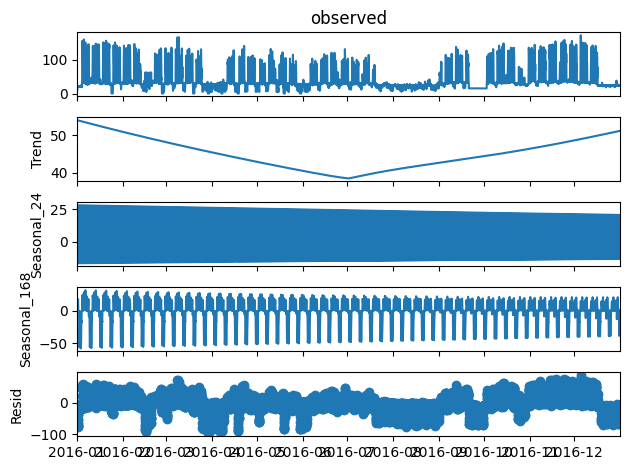

In [17]:
mstl = MSTL(series, periods=(24, 24*7), windows = [len(series)+1,len(series)+1], stl_kwargs={"trend": len(series)+1})
res = mstl.fit()
res.plot()
plt.tight_layout()
plt.show()

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=res.trend.index, y=res.trend, name='Trend Energy consumption'))
fig.update_layout(showlegend=True, font_size = 15, legend=dict(x = 0, y = 1.2))
fig.show()

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=res.seasonal.seasonal_24.index, y=res.seasonal.seasonal_24, name='Seasonal Energy consumption (daily)'))
fig.update_layout(showlegend=True, font_size = 15, legend=dict(x = 0, y = 1.2))
fig.show()

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=res.seasonal.seasonal_168.index, y=res.seasonal.seasonal_168, name='Seasonal Energy consumption (weekly)'))
fig.update_layout(showlegend=True, font_size = 15, legend=dict(x = 0, y = 1.2))
fig.show()

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=res.resid.index, y=res.resid, name='Residual Energy consumption'))
fig.add_trace(go.Scatter(x=true_anomalies.timestamp, y=res.resid[true_anomalies.timestamp], mode='markers', marker=dict(color='coral'), name='Anomalies'))
fig.update_layout(showlegend=True, font_size = 15, legend=dict(x = 0, y = 1.2))
fig.show()

Regarding other features present in the dataset...

In [ ]:
time_series_df.precip_depth_1_hr.unique()

array([  0,  -1,   3,   5,   8,   2,  10,  20,  33,  38,  13,  15,   7,
        23, 165,  18,  51,  61,  30,  81,  69,  46,  25,  56,  79,  66,
       112,  36,  53,  58, 122, 343,  76, 130, 135, 124,  68,  43,  97,
        41, 310, 234, 155,  91,  17, 104, 196,  99, 203, 142,  28, 137,
       340, 163,  27,  84, 257, 262, 160, 145, 152,  50,  74, 241, 221,
       239, 132, 236,  40, 191,  55,  -2,  86, 127,  64, 198,  48, 114,
       193,  71,  89,  11,   9,   4,   6,  21,  39,  24,  26,  16,  45,
        34,  14,  22,  37,  19,  12,  35,  32, 105, 103,  29,  31,  70,
        83, 201, 162, 164,  98,  47,  42, 113, 217,  60, 102, 107,  78,
        73, 119, 150, 175, 216,  94, 140, 333, 147, 211, 180])

Note that here the negative values correspond to precipitations so small that they can be considered as not relevant for the task.

Another interesting column is the one related to the category the model belongs to.

In [ ]:
time_series_df.primary_use.unique()

array(['Education', 'Office', 'Parking', 'Lodging/residential',
       'Entertainment/public assembly', 'Public services',
       'Manufacturing/industrial', 'Services', 'Other', 'Healthcare',
       'Food sales and service', 'Religious worship'], dtype=object)

Let's try to see which features are more important using a correlation matrix.

In [ ]:
corr_dataset = time_series_df.iloc[:, :16]
corr_dataset.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,1,2016-01-01 00:00:00,31.477940,0,0,Education,2720,104,0,19.4,255,19.4,0,967.2,0,0.0
200,1,2016-01-01 01:00:00,29.582970,0,0,Education,2720,104,0,21.1,6,21.1,-1,1019.4,0,0.0
398,1,2016-01-01 02:00:00,28.635485,0,0,Education,2720,104,0,21.1,255,21.1,0,1018.8,210,1.5
597,1,2016-01-01 03:00:00,28.161742,0,0,Education,2720,104,0,20.6,255,20.0,0,1018.1,0,0.0
796,1,2016-01-01 04:00:00,27.924871,0,0,Education,2720,104,0,21.1,255,20.6,0,1019.0,290,1.5


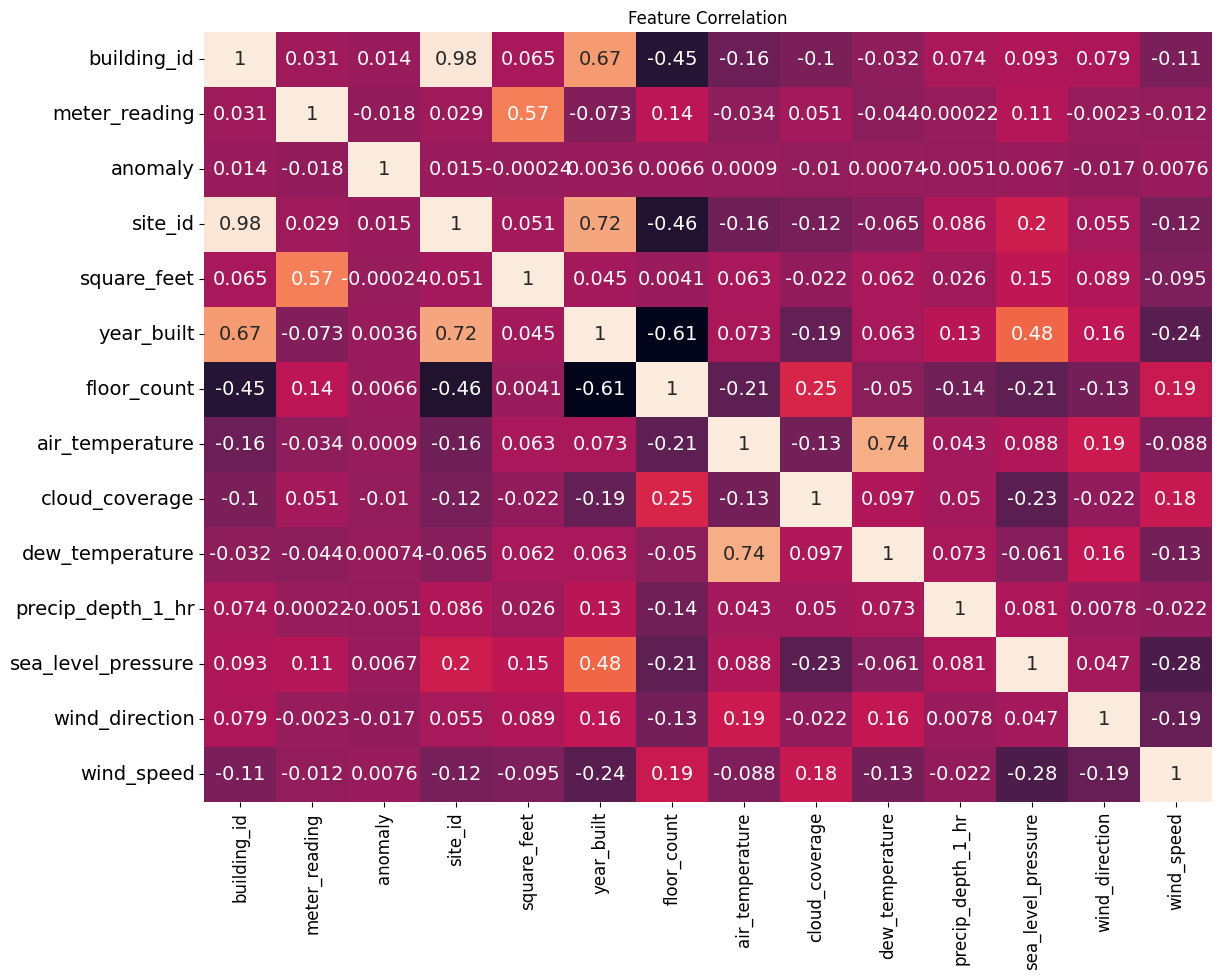

In [ ]:
plt.figure(figsize=(13,10))
g = sns.heatmap(corr_dataset.corr(), annot=True, cbar=False, annot_kws={'size': 14})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 12)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
plt.title('Feature Correlation')
plt.show()

The target of our analysis, the energy consumption measurement, is mainly correlated with the features "square_feet", "floor_count" and "sea_level_pressure".

Let's try now to understand how many anomalies each buildings has.

In [ ]:
count_anomalies = []
for bid in time_series_df.building_id.unique():
  bid_df = time_series_df[time_series_df.building_id == bid]
  anomalies = bid_df.anomaly.sum()
  count_anomalies.append((bid, anomalies))

In [ ]:
np.mean(count_anomalies[1])

45.0

On average there are 45 anomalies per each building.

Finally, let's see the percentage of anomalies in the complete training dataset, and how this results when dividing into training and validation set.

In [24]:
time_series_df.anomaly.sum()/len(time_series_df)

0.02131816399484651

In [25]:
building_ids_train = np.unique(time_series_df.building_id)
building_ids_train =[building_id for building_id in building_ids_train if building_id%5<4]

In [26]:
dfs_dict_1 = {}
for building_id, gdf in time_series_df.groupby("building_id"):
    if building_id in building_ids_train:
      dfs_dict_1[building_id] = gdf
train = pd.concat(dfs_dict_1.values())

In [27]:
train.anomaly.sum()/len(train)

0.0208368468330519

In [28]:
building_ids_val = np.unique(time_series_df.building_id)
building_ids_val =[building_id for building_id in building_ids_val if building_id%5==4]

In [29]:
dfs_dict_1 = {}
for building_id, gdf in time_series_df.groupby("building_id"):
    if building_id in building_ids_val:
      dfs_dict_1[building_id] = gdf
val= pd.concat(dfs_dict_1.values())

In [30]:
val.anomaly.sum()/len(val)

0.023370574199391588

We can see how we maintained similar proportions with respect to the complete dataset: the percentage of anomalies is around 2% in each case.

# Test set Exploration

Let's now briefly explore the test set.

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Unsupervised_Anomaly_Detection_thesis/test_features.csv')
test.shape

(1800567, 57)

The test dataset appears to be slightly bigger than the training one. Let's try to see if it is defined similarly.

In [ ]:
test.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800567 entries, 0 to 1800566
Data columns (total 57 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   row_id                         1800567 non-null  int64  
 1   building_id                    1800567 non-null  int64  
 2   timestamp                      1800567 non-null  object 
 3   meter_reading                  1705703 non-null  float64
 4   site_id                        1800567 non-null  int64  
 5   primary_use                    1800567 non-null  object 
 6   square_feet                    1800567 non-null  int64  
 7   year_built                     1800567 non-null  int64  
 8   floor_count                    1800567 non-null  int64  
 9   air_temperature                1800567 non-null  float64
 10  cloud_coverage                 1800567 non-null  int64  
 11  dew_temperature                1800567 non-null  float64
 12  precip_depth_1

In [ ]:
test.isna().sum()

row_id                               0
building_id                          0
timestamp                            0
meter_reading                    94864
site_id                              0
primary_use                          0
square_feet                          0
year_built                           0
floor_count                          0
air_temperature                      0
cloud_coverage                       0
dew_temperature                      0
precip_depth_1_hr                    0
sea_level_pressure                   0
wind_direction                       0
wind_speed                           0
air_temperature_mean_lag7            0
air_temperature_max_lag7             0
air_temperature_min_lag7             0
air_temperature_std_lag7             0
air_temperature_mean_lag73           0
air_temperature_max_lag73            0
air_temperature_min_lag73            0
air_temperature_std_lag73            0
hour                                 0
weekday                  

Also in this case the only column which contains null values is the one related to the energy consumption values, which will need to be imputed appropriately and in the same manner as for the training set.

In [ ]:
test.building_id.nunique()

206

In this case there are 206 buildings, instead of 200.

In [ ]:
num_measurements_per_bid_test = test.groupby(['building_id'])['building_id'].count().unique()
num_measurements_per_bid_test

array([8784, 8717, 8782, 8783, 8744, 8781, 8772, 8775, 8694, 8758, 8763,
       8757, 8776, 7896, 8768, 8766, 8769, 8765, 8760, 8764, 8767, 8762,
       8689, 8773, 8627, 8779, 6653, 7592, 8756, 8460, 8778, 7459, 7471])

In [ ]:
num_measurements_per_bid_test.min(), num_measurements_per_bid_test.max()

(6653, 8784)

Also for the test set, we can see how some buildigns are missing timestamps over the energy consumption measurements.

Let's now check if the buildings belong to the same categories as the training set.

In [ ]:
test.primary_use.unique()

array(['Education', 'Office', 'Lodging/residential', 'Public services',
       'Warehouse/storage', 'Entertainment/public assembly', 'Other',
       'Services', 'Retail', 'Healthcare', 'Food sales and service',
       'Utility'], dtype=object)

In [ ]:
for pu in test.primary_use.unique():
  if pu not in time_series_df.primary_use.unique():
    print(pu + " not present in the training dataset.\n")

Warehouse/storage not present in the training dataset.

Retail not present in the training dataset.

Utility not present in the training dataset.



In [ ]:
for pu in time_series_df.primary_use.unique():
  if pu not in test.primary_use.unique():
    print(pu + " not present in the training dataset.\n")

Parking not present in the training dataset.

Manufacturing/industrial not present in the training dataset.

Religious worship not present in the training dataset.



There are some categories that are present in the training set but not in the test set, and some that are present in the test set but not in the training set. This means that when performing the preprocessing steps we need to take appropriate care in handling this feature, as it is reasonable to think that these differences could cause problems (if we use for example a LabelEncoder to transform the categorical variables in quantitative ones, and try to apply the one fitted on the training on the test set, an error would occur).